In [ ]:
from ModelClass import RegressionModel
from DatasetClass import Dataset, DatasetMass
import matplotlib.pyplot as plt
import numpy as np
import itertools
from src.helpers import make_filter_slice
import tensorflow as tf

2025-03-04 23:27:01.585886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 23:27:01.607676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-04 23:27:01.614356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 23:27:01.632427: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 23:27:05.790065: E external/local_xla/xla/

In [1]:
erik_data = "/scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/*/*/*/*/*H125*.root"
patrik_data = "/scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/*/*/*/*/*Ztt*.root"


In [2]:
dataset = Dataset(file_paths=erik_data, file_name = "erik_data")
dataset.load_data()

print(len(dataset.train_dataset))

#This block of code iterates through the dataset and extracts the pt values of the labels and stores them in a list
data = [labels.numpy()[0] for features, labels in dataset.train_dataset.take(100000)]

plt.hist(data, bins=100, range=(50, 130), histtype='step', label='pt distribution', density=False)
plt.legend(loc='upper right')
plt.title('pt distribution of the dataset')
plt.xlabel('pt')
plt.ylabel('Number of events')
plt.show()



NameError: name 'Dataset' is not defined

In [2]:
dataset = DatasetMass(file_name = "Data_test")
dataset.build_dataset()
dataset.save_data()



Loading Data
Importing Root files
All files  36
Reading file /scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/mc/lephad/mc23d/nom/user.kilie.Htt_lh_02.mc23_13p6TeV.700901.Sh_2214_Ztt_maxHTpT_Mll10_40_BF.PHYS.e8514_s4159_r15224_p6266.smPre_n_0_HS.NOMINAL.root
Processed file /scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/mc/lephad/mc23d/nom/user.kilie.Htt_lh_02.mc23_13p6TeV.700901.Sh_2214_Ztt_maxHTpT_Mll10_40_BF.PHYS.e8514_s4159_r15224_p6266.smPre_n_0_HS.NOMINAL.root: (364, 35), (364, 4)
Reading file /scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/mc/lephad/mc23d/nom/user.kilie.Htt_lh_02.mc23_13p6TeV.700903.Sh_2214_Ztt_maxHTpT_Mll10_40_CVBV.PHYS.e8514_s4159_r15224_p6266.smPre_n_0_HS.NOMINAL.root
Processed file /scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/mc/lephad/mc23d/nom/user.kilie.Htt_lh_02.mc23_13p6TeV.700903.Sh_2214_Ztt_maxHTpT_Mll10_40_CVBV.PHYS.e8514_s4159_r15224_p6266.smPre_n_0_HS.NOMINAL.root: (3444, 35), (3444, 4)
Reading file /sc

(1000, 35)
tf.Tensor(
[[ 33.227985    1.8544023   3.060849  ...   0.          1.
    1.       ]
 [ 52.85285    -1.5960264  -2.898494  ...   0.          1.
    1.       ]
 [ 34.86298     0.8143332   1.0132009 ...   1.          0.
    1.       ]
 ...
 [114.42966    -1.9347937  -1.4136082 ...   0.          1.
    1.       ]
 [ 47.927074    2.1533992   3.106295  ...   0.          1.
    1.       ]
 [226.94508    -1.3582363   1.4977618 ...   1.          0.
    1.       ]], shape=(1000, 35), dtype=float32)


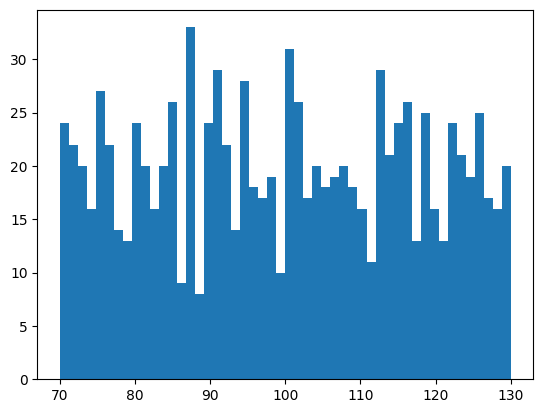

In [23]:
dataset.make_slices(n_slices=20)
slices = dataset.slices   

lorentz_mask = tf.constant(dataset.get_lorentz_mask())  # Shape [35] bool values
lorentz_indices = tf.squeeze(tf.where(lorentz_mask), axis=1) # [0 1 2 3 4 5 6 7 13 14 ...] 
n_vectors = tf.shape(lorentz_indices)[0] // 4 # number of 4-vectors
lorentz_indices_4d = tf.reshape(lorentz_indices, (n_vectors, 4))  # [n_vectors, 4]

@tf.function
def augment_lorentz(data, target):
    beta = tf.random.uniform(shape = (), minval=0.0, maxval=1.0) # Shape ()
    gamma = 1.0 / tf.sqrt(1.0 - beta**2) # Shape ()
    
    for i in range(n_vectors):
        vec_indices = lorentz_indices_4d[i] # Shape (4,)
        pt = data[vec_indices[0]] # scalar values
        eta = data[vec_indices[1]]
        phi = data[vec_indices[2]]
        E = data[vec_indices[3]]
        #print(E.shape)
        
        # Convert to Cartesian coordinates
        #px = pt * tf.cos(phi)
        #py = pt * tf.sin(phi)
        pz = pt * tf.sinh(eta) # Shape ()
    
        #TODO  c == 1 ? 
        E_prime = gamma * (E - beta * pz) # Shape ()
        pz_prime = gamma * (pz - beta * E) 
        
        epsilon = 1e-8
        eta_prime = tf.asinh(pz_prime / (pt + epsilon)) # Shape ()

        update_indices = tf.reshape(vec_indices, [-1, 1])  # Shape (4, 1)
        update_values = tf.stack([pt, eta_prime, phi, E_prime]) # Shape (4,)
        # Update the tensor
        data = tf.tensor_scatter_nd_update(
            data,
            indices=update_indices,
            updates=update_values
        )
        #print(data.shape)
        
    return data, target

n_events = 1000
new_dataset = tf.data.Dataset.sample_from_datasets([s.repeat() for s in slices], weights=[1.]*len(slices))
new_dataset = new_dataset.take(n_events)

new_dataset = new_dataset.map(augment_lorentz)
batch_dataset = new_dataset.batch(n_events)

features, masses = next(iter(batch_dataset))
print(features.shape)
print(features)

plt.hist(masses, range=(70, 130), bins=50)
plt.show()



(1, 35, 35)
tf.Tensor(
[[[33.45006    0.4904686 -1.0283544 ...  0.         1.         1.       ]
  [33.45006    0.4904686 -2.8740354 ...  0.         1.         1.       ]
  [33.45006    0.4904686 -2.5219815 ...  0.         1.         1.       ]
  ...
  [33.45006    0.4904686 -1.0353211 ...  0.         1.         1.       ]
  [33.45006    0.4904686  2.1112525 ...  0.         1.         1.       ]
  [33.45006    0.4904686 -2.5103178 ...  0.         1.         1.       ]]], shape=(1, 35, 35), dtype=float32)


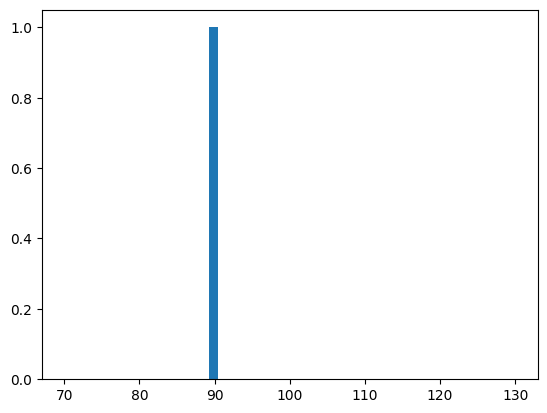

In [22]:
dataset.make_slices(n_slices=2)
slices = dataset.slices 
phi_mask = tf.constant(dataset.get_phi_mask())

@tf.function
def augment_phi(data, target):
    # generate random rotation angle
    angle = tf.random.uniform(shape=(tf.shape(data)[0],), minval=-np.pi, maxval=np.pi)
    # apply rotation
    data  = tf.where(phi_mask[tf.newaxis, :], data + angle[:, tf.newaxis], data)
    
    # normalize angles between -pi and pi
    data = tf.where(phi_mask[tf.newaxis, :], tf.math.atan2(tf.sin(data), tf.cos(data)), data)
    
    return data, target

# sample from the slices
n_events = 1
new_dataset = tf.data.Dataset.sample_from_datasets([s.repeat() for s in slices], weights=[1.]*len(slices))
new_dataset = new_dataset.take(n_events)

# apply augmentation
new_dataset = new_dataset.map(augment_phi)
batch_dataset = new_dataset.batch(n_events)
features, masses = next(iter(batch_dataset))
print(features.shape)
print(features)

plt.hist(masses, range=(70, 130), bins=50)
plt.show()




In [ ]:
dataset = Dataset(file_paths=erik_data, file_name = "erik_data")
dataset.load_data()

print(len(dataset.train_dataset))
param_grid = {
    'batch_size': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [10, 20, 30]
}

iterable = list(itertools.product(*param_grid.values()))
for params in iterable:
    model = RegressionModel(dataset=dataset, batch_size=params[0], initial_learning_rate=params[1], n_epochs=params[2])
    model.prepare_dataset()
    model.create_normalizer()
    model.build_model()
    model.train_model(model.train_batch, model.val_batch)
    model.plot_history(model.history)

6523673
Batching datasets...
Building model...
Training model...
Epoch 1/10


2025-01-29 01:07:34.276361: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


203865/203865 ━━━━━━━━━━━━━━━━━━━━ 220s 1ms/step - loss: 6972.8779 - mean_squared_error: 6972.8779 - val_loss: 6874.8071 - val_mean_squared_error: 6874.8286
Epoch 2/10
203825/203865 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 6946.1182 - mean_squared_error: 6946.1182